In [117]:
import pickle
import plotly
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
import plotly.offline as py
# import plotly_express as px
import plotly.io as pio
import plotly.graph_objects as go

from itertools import chain, repeat
from collections import Counter
# from IPython.core.interactiveshell import InteractiveShell
# import ipywidgets as widgets|
# from ipywidgets import interact, interact_manual
pio.renderers.default='jupyterlab'



## [ 불량 유형별 원인 인자 탐색 ]

In [126]:
labeled = pd.read_csv('./../dataset/labeled_new.csv')
labeled = labeled.drop_duplicates()
X_train_scaled = pd.read_csv('./../dataset/labeled_X_train_scaled.csv')

with open('./../dataset/scaling_model.pkl', 'rb') as f:
    scaling = pickle.load(f)

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\sklearn\base.py:324: UserWarning:

Trying to unpickle estimator Normalizer from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\sklearn\base.py:324: UserWarning:

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\sklearn\base.py:324: UserWarning:

Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid resul

In [133]:
labeled_scaling = scaling.transform(labeled.iloc[:, 9:])
labeled_scaling = pd.DataFrame(labeled_scaling, columns = labeled.iloc[:, 9:].columns)
labeled_scaling['Reason'] = labeled['Reason']

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\sklearn\base.py:438: UserWarning:

X has feature names, but Normalizer was fitted without feature names



In [129]:
model_path = './../model/self_superviser_classifier.hdf5'
model = tf.keras.models.load_model(model_path)
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                405       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_add_1 (Dense)          (None, 3)                 12        
_________________________________________________________________
dense_add_2 (Dense)          (None, 3)                 12        
_________________________________________________________________
dense_add_3 (Dense)          (None, 3)                

In [130]:
explainer_shap = shap.DeepExplainer(model=model, data=X_train_scaled.values)

In [134]:
def get_total_shap_values(shap_values, data):
    total_shap = np.mean(abs(shap_values), axis=0)
    total_shap_df = pd.Series(total_shap, index=data.columns)
    total_shap_df = total_shap_df.sort_values(ascending=False)
    return total_shap_df


fail_types = set(labeled['Reason']) # {'초기허용불량', '가스', 'None', '미성형'}
fail_df = labeled_scaling.loc[labeled_scaling['Reason']!= 'None', :]


fail_df['Reason'].value_counts()

type_1_df = fail_df.loc[fail_df['Reason']=='가스', X_train_scaled.columns]
type_2_df = fail_df.loc[fail_df['Reason']=='초기허용불량', X_train_scaled.columns]
type_3_df = fail_df.loc[fail_df['Reason']=='미성형', X_train_scaled.columns]

## shape value
type_1_shap_values = explainer_shap.shap_values(type_1_df.values)
type_2_shap_values = explainer_shap.shap_values(type_2_df.values)
type_3_shap_values = explainer_shap.shap_values(type_3_df.values)


In [135]:
class ShapeObject:
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values
        self.data = data
        self.values = values
        self.feature_names = feature_names

def draw_observe_waterfall(explainer, data, original_data, charting_cnt=2):
    if len(data.index) > charting_cnt:
        charting_idx = np.random.choice(data.index, charting_cnt, replace=False)
    else:
        charting_idx = data.index
    shap_values = explainer.shap_values(data.loc[charting_idx, ].values)[0]

    for i, data_i in enumerate(charting_idx):
        original_value = original_data.loc[data_i, :]
        shap_obj = ShapeObject(base_values=explainer.expected_value[0],
                               values=shap_values[i, :],
                               feature_names=data.columns,
                               data=original_value)

        plt.figure(figsize=(10,10))
        shap.plots.waterfall(shap_obj, show=False)
        plt.title(f'index: {data_i}')
        plt.tight_layout()
        plt.show()


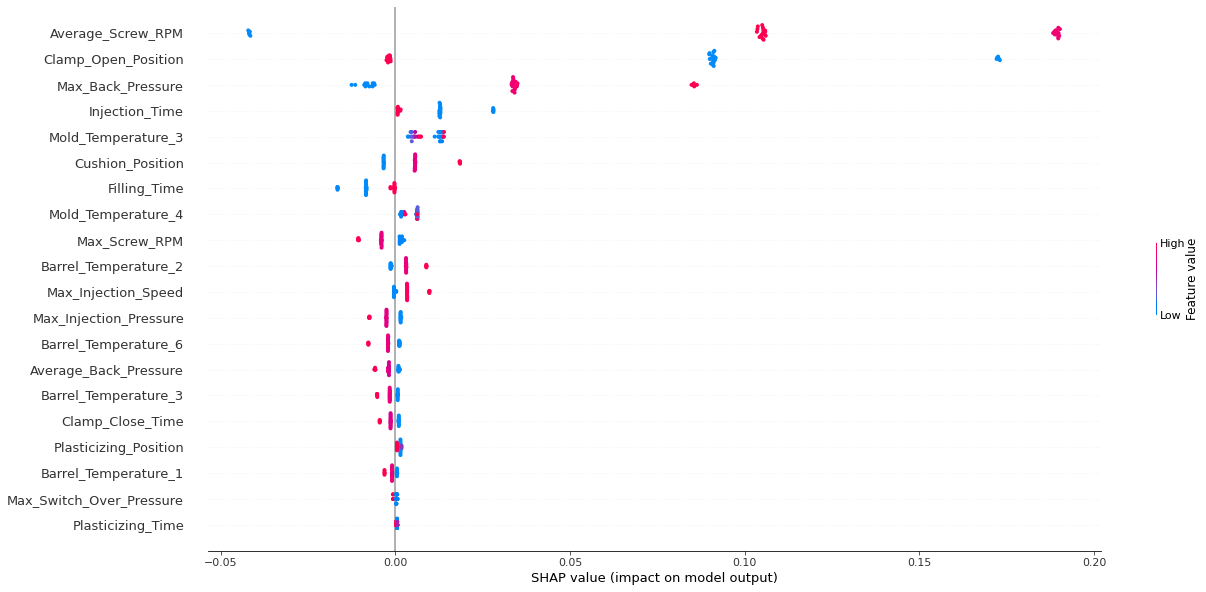

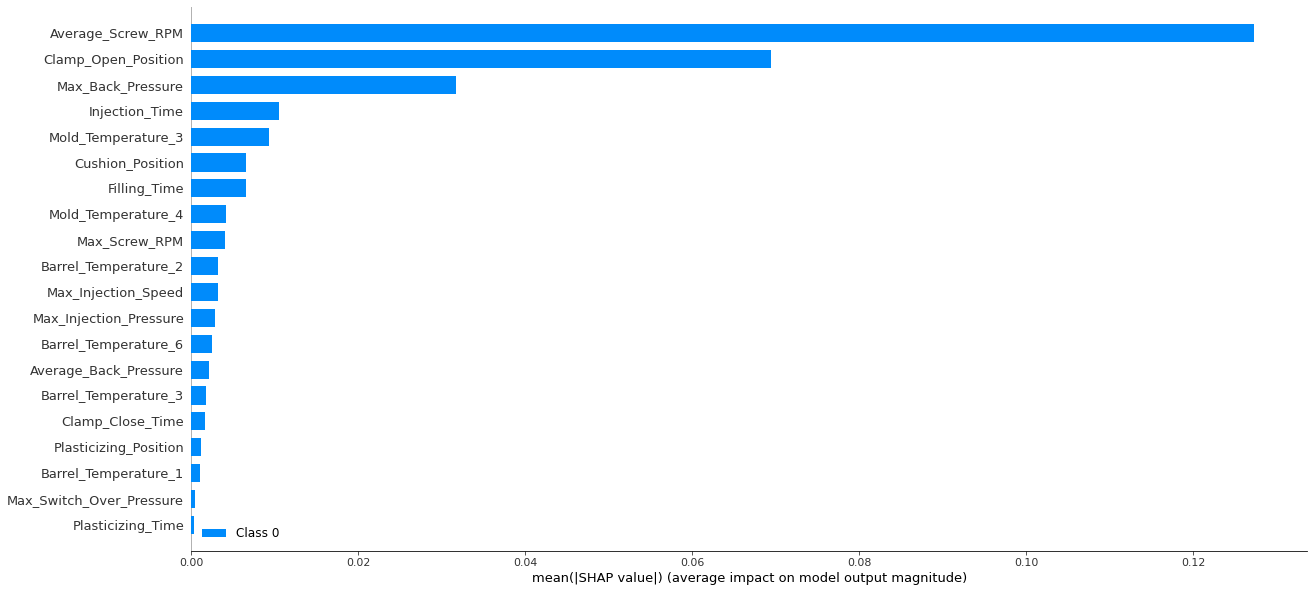

Average_Screw_RPM           0.127284
Clamp_Open_Position         0.069465
Max_Back_Pressure           0.031705
Injection_Time              0.010504
Mold_Temperature_3          0.009299
Cushion_Position            0.006620
Filling_Time                0.006599
Mold_Temperature_4          0.004162
Max_Screw_RPM               0.004084
Barrel_Temperature_2        0.003240
Max_Injection_Speed         0.003159
Max_Injection_Pressure      0.002870
Barrel_Temperature_6        0.002544
Average_Back_Pressure       0.002130
Barrel_Temperature_3        0.001778
Clamp_Close_Time            0.001657
Plasticizing_Position       0.001117
Barrel_Temperature_1        0.001079
Max_Switch_Over_Pressure    0.000402
Plasticizing_Time           0.000390
Switch_Over_Position        0.000317
Hopper_Temperature          0.000245
Barrel_Temperature_4        0.000173
Barrel_Temperature_5        0.000164
Cycle_Time                  0.000039
Barrel_Temperature_7        0.000000
dtype: float64


In [136]:
shap.summary_plot(type_1_shap_values[0], type_1_df, plot_size=(20, 10))
shap.summary_plot(type_1_shap_values, type_1_df, plot_size=(20,10))
type1_total_shap_df = get_total_shap_values(type_1_shap_values[0], type_1_df)
print(type1_total_shap_df)



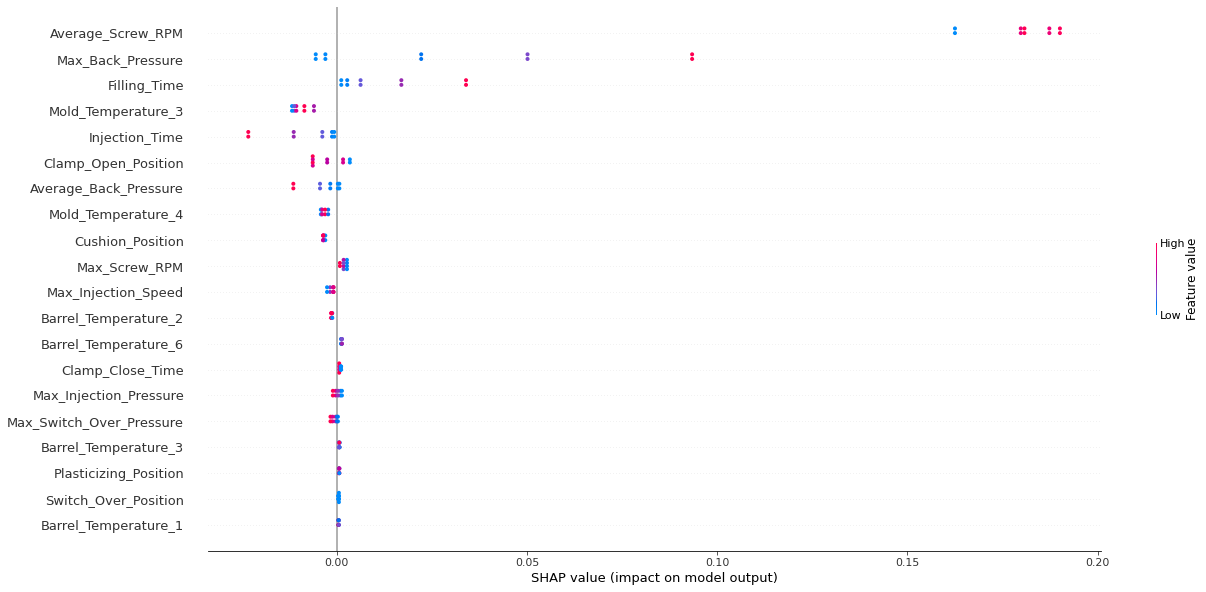

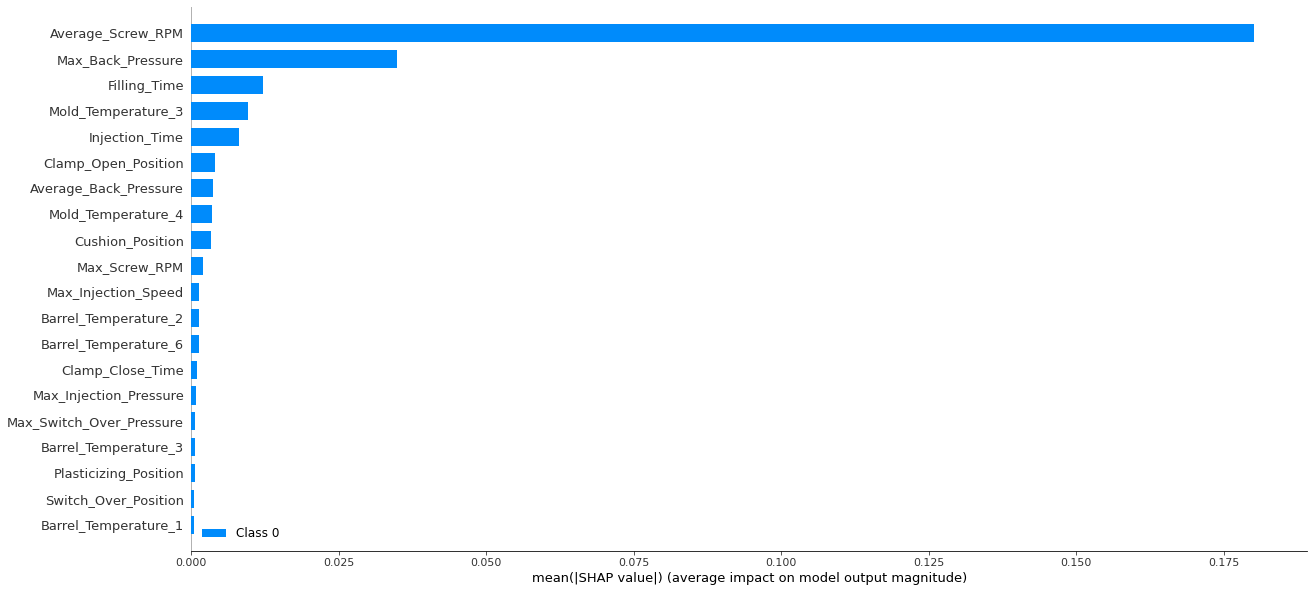

Average_Screw_RPM           0.180104
Max_Back_Pressure           0.034855
Filling_Time                0.012233
Mold_Temperature_3          0.009612
Injection_Time              0.008055
Clamp_Open_Position         0.004047
Average_Back_Pressure       0.003698
Mold_Temperature_4          0.003465
Cushion_Position            0.003412
Max_Screw_RPM               0.001958
Max_Injection_Speed         0.001400
Barrel_Temperature_2        0.001329
Barrel_Temperature_6        0.001263
Clamp_Close_Time            0.000916
Max_Injection_Pressure      0.000801
Max_Switch_Over_Pressure    0.000688
Barrel_Temperature_3        0.000657
Plasticizing_Position       0.000626
Switch_Over_Position        0.000515
Barrel_Temperature_1        0.000487
Plasticizing_Time           0.000462
Hopper_Temperature          0.000170
Barrel_Temperature_4        0.000097
Barrel_Temperature_5        0.000075
Cycle_Time                  0.000007
Barrel_Temperature_7        0.000000
dtype: float64


In [137]:
shap.summary_plot(type_2_shap_values[0], type_2_df, plot_size=(20, 10))
shap.summary_plot(type_2_shap_values, type_2_df, plot_size=(20,10))
type2_total_shap_df = get_total_shap_values(type_2_shap_values[0], type_2_df)
print(type2_total_shap_df)

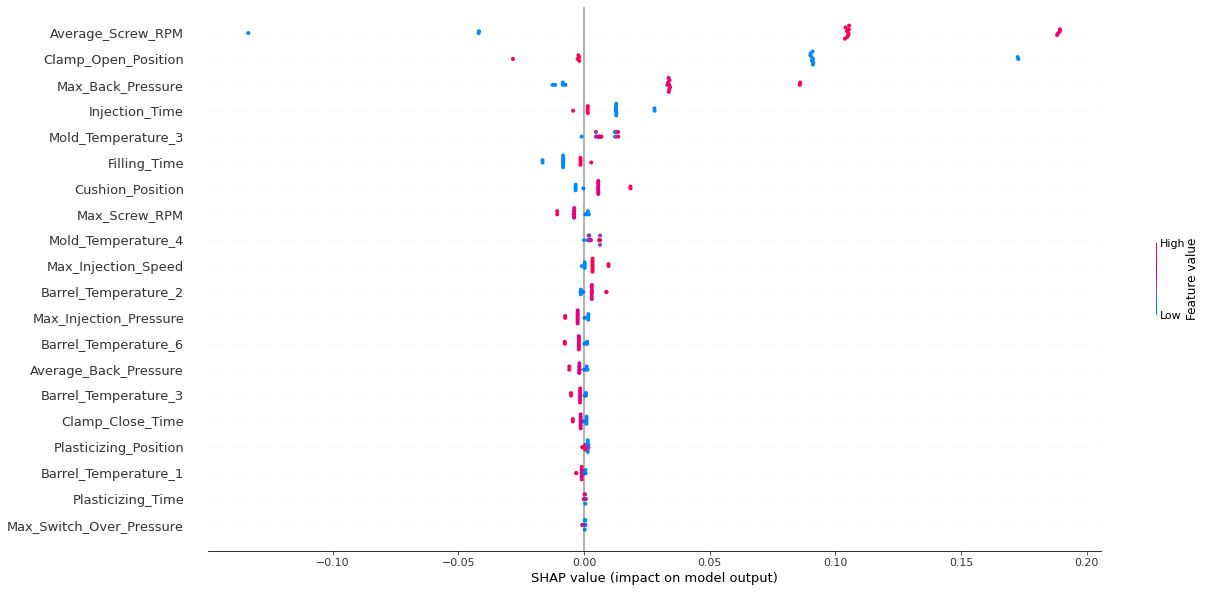

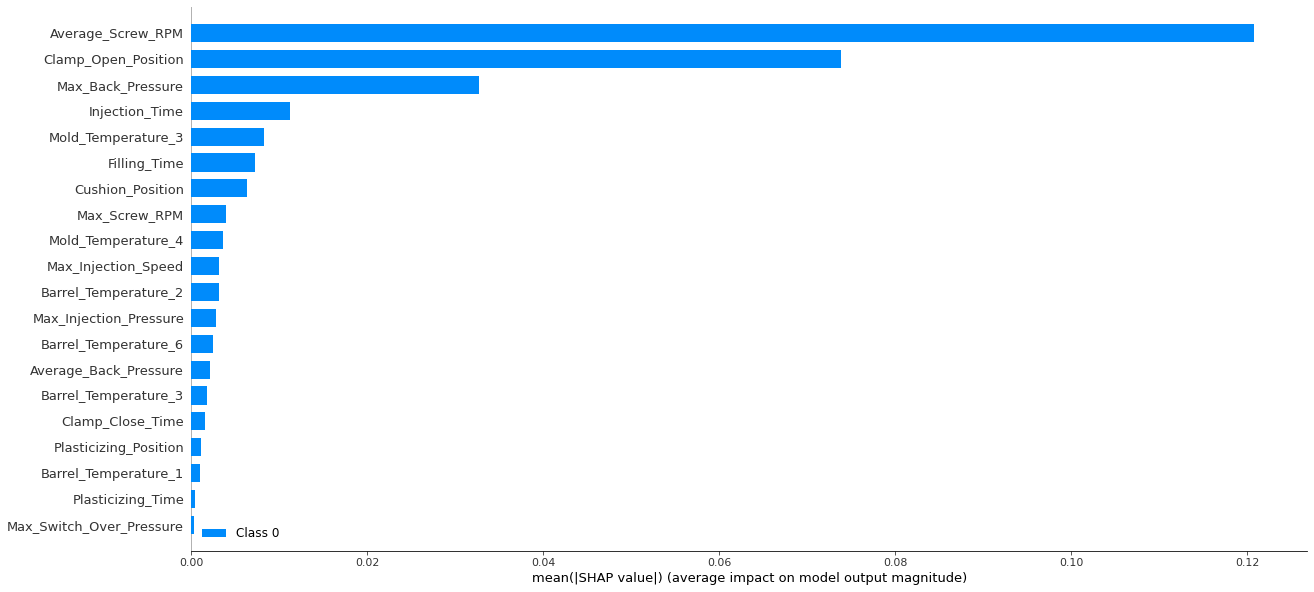

Average_Screw_RPM           0.120784
Clamp_Open_Position         0.073884
Max_Back_Pressure           0.032684
Injection_Time              0.011214
Mold_Temperature_3          0.008275
Filling_Time                0.007241
Cushion_Position            0.006382
Max_Screw_RPM               0.004008
Mold_Temperature_4          0.003600
Max_Injection_Speed         0.003209
Barrel_Temperature_2        0.003195
Max_Injection_Pressure      0.002827
Barrel_Temperature_6        0.002462
Average_Back_Pressure       0.002103
Barrel_Temperature_3        0.001747
Clamp_Close_Time            0.001587
Plasticizing_Position       0.001169
Barrel_Temperature_1        0.001055
Plasticizing_Time           0.000385
Max_Switch_Over_Pressure    0.000365
Switch_Over_Position        0.000280
Hopper_Temperature          0.000256
Barrel_Temperature_4        0.000166
Barrel_Temperature_5        0.000166
Cycle_Time                  0.000040
Barrel_Temperature_7        0.000000
dtype: float64


In [138]:
shap.summary_plot(type_3_shap_values[0], type_3_df, plot_size=(20, 10))
shap.summary_plot(type_3_shap_values, type_3_df, plot_size=(20,10))
type3_total_shap_df = get_total_shap_values(type_3_shap_values[0], type_3_df)
print(type3_total_shap_df)


## [불량 원인 인자에 따른 근본 요인 분석]


### 타입별 top10원인 인자

In [139]:
factor_cnt = 10
type_1_factor = type1_total_shap_df[:factor_cnt]
type_1_factor_list = type_1_factor.index
print('Type1:', type_1_factor_list)

type_2_factor = type2_total_shap_df[:factor_cnt]
type_2_factor_list = type_2_factor.index
print('Type2:', type_2_factor_list)

type_3_factor = type3_total_shap_df[:factor_cnt]
type_3_factor_list = type_3_factor.index
print('Type3:', type_3_factor_list)



Type1: Index(['Average_Screw_RPM', 'Clamp_Open_Position', 'Max_Back_Pressure',
       'Injection_Time', 'Mold_Temperature_3', 'Cushion_Position',
       'Filling_Time', 'Mold_Temperature_4', 'Max_Screw_RPM',
       'Barrel_Temperature_2'],
      dtype='object')
Type2: Index(['Average_Screw_RPM', 'Max_Back_Pressure', 'Filling_Time',
       'Mold_Temperature_3', 'Injection_Time', 'Clamp_Open_Position',
       'Average_Back_Pressure', 'Mold_Temperature_4', 'Cushion_Position',
       'Max_Screw_RPM'],
      dtype='object')
Type3: Index(['Average_Screw_RPM', 'Clamp_Open_Position', 'Max_Back_Pressure',
       'Injection_Time', 'Mold_Temperature_3', 'Filling_Time',
       'Cushion_Position', 'Max_Screw_RPM', 'Mold_Temperature_4',
       'Max_Injection_Speed'],
      dtype='object')


In [140]:
data = pd.read_csv('./../dataset/labeled_new.csv')

### 공정 순서 별 컬럼 정의

In [141]:
y_col = ['PassOrFail']
step_1_cols = ['Plasticizing_Time', 'Hopper_Temperature', 'Mold_Temperature_3', 'Mold_Temperature_4']
step_from_1_cols = ['Cycle_Time', 'Barrel_Temperature_1', 'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
                    'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Barrel_Temperature_7']
step_2_cols = ['Clamp_Close_Time']
step_3_cols = ['Injection_Time', 'Filling_Time', 'Max_Injection_Speed']
step_from_3_cols = ['Max_Screw_RPM', 'Average_Screw_RPM', 'Max_Injection_Pressure']
step_4_cols = ['Cushion_Position', 'Switch_Over_Position', 'Plasticizing_Position', 'Max_Switch_Over_Pressure']
step_5_cols = ['Max_Back_Pressure', 'Average_Back_Pressure']
step_6_cols = ['Clamp_Open_Position']

total_cols = y_col+step_1_cols+step_from_1_cols+step_2_cols+step_3_cols+step_from_3_cols+step_4_cols+step_5_cols+step_6_cols

total_cols_2d = [y_col, step_1_cols, step_from_1_cols, step_2_cols,
                 step_3_cols, step_from_3_cols, step_4_cols, step_5_cols, step_6_cols]

total_cols = list(chain(*total_cols_2d))


### X인자 간 상관관계

In [142]:
def get_pearson_corr_df(data):
    corr_mat = np.corrcoef(data.values, rowvar=False)
    corr_df = pd.DataFrame(corr_mat, columns=data.columns, index=data.columns)
    return corr_df

In [148]:
type1_X_corr = get_pearson_corr_df(type_1_df)
type2_X_corr = get_pearson_corr_df(type_2_df)
type3_X_corr = get_pearson_corr_df(type_3_df)

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\sherr\anaconda3\envs\kamp_2021\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning:

invalid value encountered in true_divide



In [144]:
type1_X_corr

,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,Clamp_Open_Position,Max_Injection_Speed,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Barrel_Temperature_7,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
Injection_Time,1.000000,0.999912,0.929487,-0.986013,-0.970124,-0.981837,NaN,0.946467,0.999956,-0.998870,...,-0.986789,-0.986902,-0.986367,-0.984534,-0.987263,-0.984524,NaN,-0.978135,-0.718491,-0.268426
Filling_Time,0.999912,1.000000,0.931659,-0.984740,-0.968397,-0.980451,NaN,0.948377,0.999749,-0.998705,...,-0.985615,-0.985670,-0.985122,-0.983250,-0.986065,-0.983201,NaN,-0.977289,-0.715588,-0.263337
Plasticizing_Time,0.929487,0.931659,1.000000,-0.855655,-0.812660,-0.843043,NaN,0.998180,0.927433,-0.912170,...,-0.858130,-0.858478,-0.856611,-0.851879,-0.859598,-0.851002,NaN,-0.872558,-0.533668,-0.004123
Cycle_Time,-0.986013,-0.984740,-0.855655,1.000000,0.996813,0.999633,NaN,-0.879791,-0.986981,0.991979,...,0.999774,0.999819,0.999876,0.999488,0.999809,0.999827,NaN,0.980857,0.770991,0.378979
Clamp_Close_Time,-0.970124,-0.968397,-0.812660,0.996813,1.000000,0.998477,NaN,-0.840117,-0.971495,0.979510,...,0.996381,0.996330,0.996710,0.996986,0.996210,0.997489,NaN,0.972736,0.787620,0.425567
Cushion_Position,-0.981837,-0.980451,-0.843043,0.999633,0.998477,1.000000,NaN,-0.868161,-0.982911,0.988910,...,0.999455,0.999463,0.999619,0.999492,0.999434,0.999828,NaN,0.978951,0.777781,0.394850
Switch_Over_Position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plasticizing_Position,0.946467,0.948377,0.998180,-0.879791,-0.840117,-0.868161,NaN,1.000000,0.944678,-0.931120,...,-0.882023,-0.882377,-0.880696,-0.876009,-0.883350,-0.875543,NaN,-0.895026,-0.556880,-0.030037
Clamp_Open_Position,0.999956,0.999749,0.927433,-0.986981,-0.971495,-0.982911,NaN,0.944678,1.000000,-0.998939,...,-0.987695,-0.987830,-0.987310,-0.985494,-0.988172,-0.985531,NaN,-0.978860,-0.720654,-0.272347
Max_Injection_Speed,-0.998870,-0.998705,-0.912170,0.991979,0.979510,0.988910,NaN,-0.931120,-0.998939,1.000000,...,0.992638,0.992653,0.992286,0.990896,0.992940,0.990892,NaN,0.981019,0.734356,0.298058


### X-y 관계확인을 위한 shap value 할당

In [145]:
def assign_shap_value(corr_data, shap_table):
    corr_data['PassOrFail'] = np.zeros(len(corr_data))
    shap_factors = shap_table.index
    shap_values = shap_table.values
    for factor in shap_factors:
        corr_data.loc[factor, 'PassOrFail'] = shap_table[factor]
    add_row = np.concatenate([corr_data['PassOrFail'].values, np.zeros(1)])

    corr_data.loc['PassOrFail'] = add_row
    return corr_data

In [149]:
type1_relations = assign_shap_value(type1_X_corr, type_1_factor)
type2_relations = assign_shap_value(type2_X_corr, type_2_factor)
type3_relations = assign_shap_value(type3_X_corr, type_3_factor)



## [ 근본인자 시각화를 위한 Sankey Chart ]

In [ ]:
### 함수 정의

In [153]:
def make_feature_dictionary(feat_total_list: list) -> dict:
    feat_dictionary = {feat: index for index, feat in enumerate(feat_total_list)}
    return feat_dictionary

def make_source_target_table(data: pd.DataFrame, feat_dict: dict, pre_feats: list, next_feats: list) -> pd.DataFrame:
    selected_df = data.loc[pre_feats, next_feats]
    if not selected_df.empty:
        src_tg_table = selected_df.stack().reset_index()
        src_tg_table.columns = ['source', 'target', 'value']
        src_tg_table['source_i'] = src_tg_table['source'].apply(lambda x : feat_dict[x])
        src_tg_table['target_i'] = src_tg_table['target'].apply(lambda x: feat_dict[x])
    else:
        src_tg_table = pd.DataFrame(columns = ['source', 'target', 'value'])
    return src_tg_table


def get_features_match_over_limit(pre_data: pd.DataFrame, match_data: pd.DataFrame, limit: float) -> list:
    match_cols = match_data.index
    selected_feats = [i for i, v in pre_data.iterrows() if any(abs(v[match_cols]) > limit)]
    return selected_feats


def make_chart_data(data: pd.DataFrame, y_corr_min:float, between_step_corr_min: float)\
    -> (pd.DataFrame, dict):
    # between_step_corr_min = 0.7
    # y_corr_min = 0.07

    y_df = data.loc[y_col, :]
    step_1 = data.loc[step_1_cols, : ]
    step_from_1 = data.loc[step_from_1_cols, :]
    step_2 = data.loc[step_2_cols, :]
    step_3 = data.loc[step_3_cols, :]
    step_from_3 = data.loc[step_from_3_cols, :]
    step_4 = data.loc[step_4_cols, :]
    step_5 = data.loc[step_5_cols, :]
    step_6 = data.loc[step_6_cols, :]
    data_for_X_realtion = [step_1, step_2, step_3, step_4, step_5, step_6]
    data_for_y_realtion = [step_1, step_2, step_3, step_4, step_5, step_6, step_from_1, step_from_3]

    feat_dict = make_feature_dictionary(total_cols)


    total_step = 6
    feats = {}
    for i, x_comp in enumerate(data_for_X_realtion):
        if i+1 < len(data_for_X_realtion):
            selected_feat = get_features_match_over_limit(x_comp, data_for_X_realtion[i+1],
                                                          between_step_corr_min)
            feats[i+1] = selected_feat


    between_y_feats = {}
    for i, y_comp in enumerate(data_for_y_realtion):
        selected_feat = get_features_match_over_limit(y_comp, y_df, y_corr_min)
        between_y_feats[i] = selected_feat

    # X간 관계 테이블
    src_tg_table = pd.DataFrame()

    for step, feat in feats.items():
        if feats and step+1 < len(feats.keys()):
            table = make_source_target_table(data_for_X_realtion[step], feat_dict, feats[step+1], feats[step + 2])
            src_tg_table = pd.concat([src_tg_table, table], ignore_index=True)

    # y간 관계 테이블
    for i, y_comp in enumerate(data_for_y_realtion):
        if between_y_feats[i]:
            table = make_source_target_table(y_comp, feat_dict, between_y_feats[i], y_col)
            src_tg_table = pd.concat([src_tg_table, table], ignore_index=True)

    return src_tg_table, feat_dict



def show_causation_chart(data, y_relation_abs_min=0.07,
                                      between_step_corr_min=0.8):
    src_tg_table, feat_dict = make_chart_data(data, y_relation_abs_min, between_step_corr_min)

    labels = list(feat_dict.keys())
    source = src_tg_table['source_i'].values.tolist()
    target = src_tg_table['target_i'].values.tolist()
    value_org = [f'real value : {round(v, 3)}' for v in src_tg_table['value'].values.tolist()]
    value = [abs(v)*100 for v in src_tg_table['value'].values]

    fig = go.FigureWidget(
        data=[go.Sankey(
            node=dict(
                pad=10,
                thickness=10,
                line=dict(width=0.5),
                label=labels,
                #x=x_loc,
                #y=y_loc
            ),
            link=dict(source=source,
                      target=target,
                      value=value,
                      label=value_org,
                      ),
            valueformat='.3r'
        )],
        layout=go.Layout(
            height=1000,
            margin=go.layout.Margin(
                l=10,  # left margin
                r=10,  # right margin
                b=100,  # bottom margin
                t=10,  # top margin
            )
        )
    )

    # notebook show
    py.iplot(fig)

차트 생성

Type1

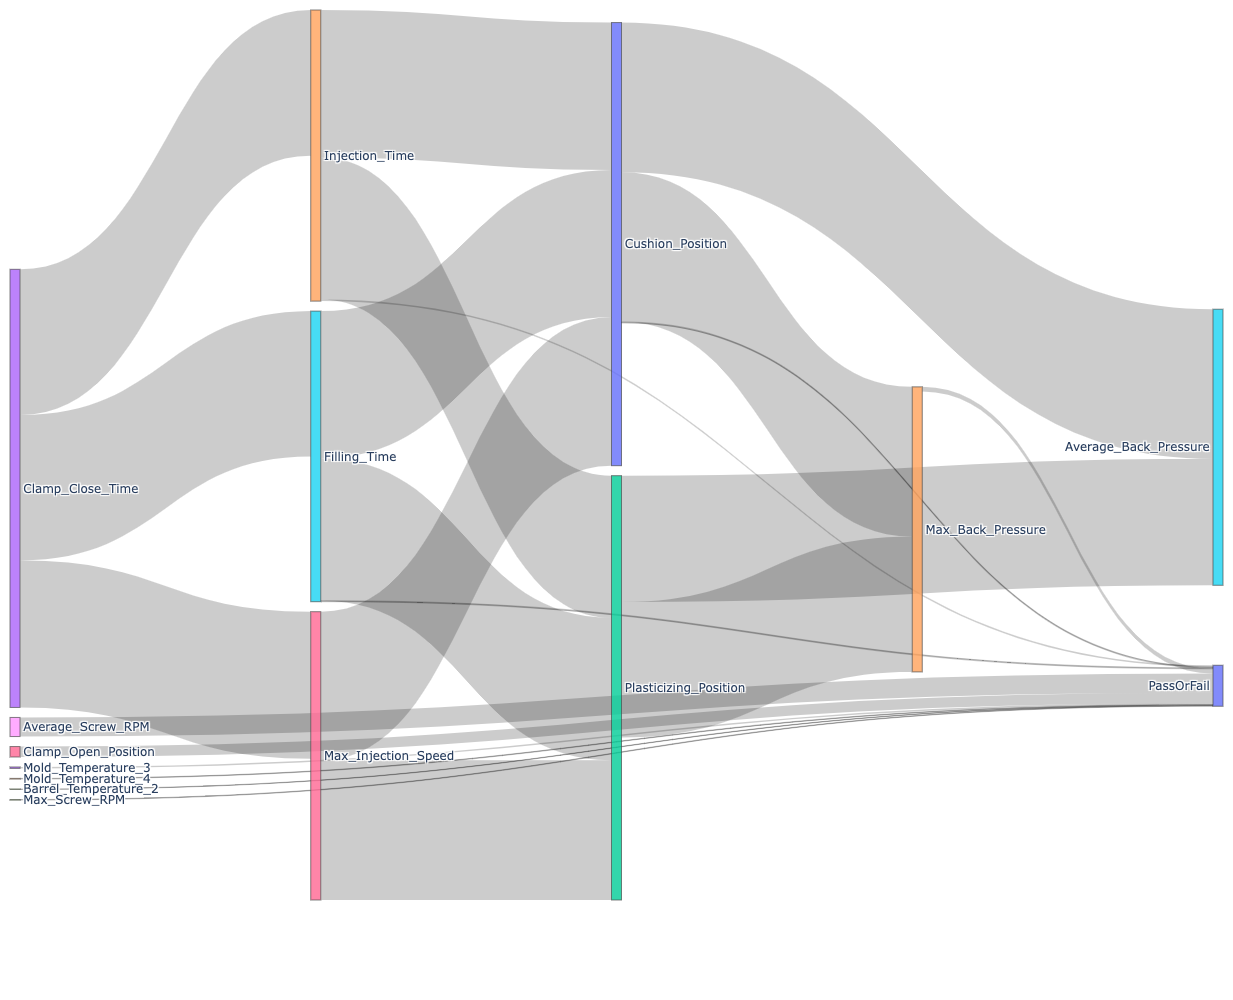

In [154]:
y_shap_abs_min = 0.001
between_step_corr_min = 0.8
show_causation_chart(type1_relations, y_shap_abs_min, between_step_corr_min)


Type2

In [155]:
y_shap_abs_min = 0.001
between_step_corr_min = 0.8
show_causation_chart(type2_relations, y_shap_abs_min, between_step_corr_min)


Type3

In [156]:
y_shap_abs_min = 0.001
between_step_corr_min = 0.8
show_causation_chart(type3_relations, y_shap_abs_min, between_step_corr_min)

